#### Data processing

In [32]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer , matthews_corrcoef , classification_report

In [10]:
diabetes_data = pd.read_csv("datasets/diabetes_012_health_indicators_BRFSS2015.csv")
diabetes_data.head(10)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


From the column description in the data_analysis.ipynb script and from the data above we can see that we have:  
binary columns  
ordinal columns  
1 continous column (BMI)  

For tree-based models, I can use the dataset as it is now. But for other models, such as SVMs, the continous column needs to be normalized.
The ordinal columns can stay untouched since they represent an intrinsic hierarchy of the feature (for example: age feature: 1 = very young, 13 = very old)  

To make this data usable for all ML algorithms I need to normalize the BMI column only

#### Training and Benchmark set creation

Benchmark set will never be used for training or validation of the models, it will only be used to evaluate model performance later  
Bnehcmark set will consists of 20 % of the total dataset with class imbalance proportion maintained

In [11]:
# Healthy: 0.842
# Pre-diabetic: 0.018
# Diabetic: 0.139

# First shuffle data
data_split = diabetes_data.sample(frac=1 , random_state=3).reset_index(drop=True)

# Count diabetics, prediabetics, and healthy
class_counts = data_split['Diabetes_012'].value_counts()

# Count 20% 
d=int(class_counts[2]*20 / 100)
p=int(class_counts[1]*20 / 100)
h=int(class_counts[0]*20 / 100)
print(d , p , h)

# Create splits with only 1 class

data_split_d=data_split.query("Diabetes_012 == 2")
data_split_p=data_split.query("Diabetes_012 == 1")
data_split_h=data_split.query("Diabetes_012 == 0")

# Take the first n entries to respect proportions (we can to this since we shuffled the data)

data_split_d20 = data_split_d.iloc[:d , :]
data_split_p20 =data_split_p.iloc[:p , :]
data_split_h20 =data_split_h.iloc[:h , :]

# merge into a single dataframe

benchmark_set = pd.concat([data_split_d20 , data_split_p20 , data_split_h20] , axis=0)

# remove benchmark set indexes from training set

training_set = data_split.drop(benchmark_set.index)

7069 926 42740


In [12]:
# create x and y and save them for later use

benchmark_vector = benchmark_set["Diabetes_012"].to_numpy()
training_vector = training_set["Diabetes_012"].to_numpy()

benchmark_x=benchmark_set.drop( columns=["Diabetes_012"])
training_x=training_set.drop( columns=["Diabetes_012"])

training_x.to_pickle("x_training.pkl")
benchmark_x.to_pickle("x_benchmark.pkl")

with open("y_training.pkl" , "wb") as f:
    pickle.dump(training_vector ,f)

with open("y_benchmark.pkl" , "wb") as f:
    pickle.dump(benchmark_vector ,f)

In [13]:
# Checks:

print("Dataset length in total dataset:", len(data_split))
print("Benchmark set length", len(benchmark_set))
print("EXPECTED training set length", len(data_split) - len(benchmark_set))
print("REAL training set length", len(training_set))

overlap = training_set.index.isin(benchmark_set.index).sum()
print("Overlap rows", overlap)

Dataset length in total dataset: 253680
Benchmark set length 50735
EXPECTED training set length 202945
REAL training set length 202945
Overlap rows 0


#### Feature Selection

To perform feature selection, I will use a RandomForestClassifier 

In [15]:
# initialize the classifier

rf_selector = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1
)

# 10 fold cross-cv
# with stratified k fold the class proportions are maintained. This is crucial to avoid splits in which the 1 class (pre-diabetic) is absent, since its very little represented
cv_class_prop = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# MCC as scoring method since its suitable for unbalanced classes
mcc_scorer = make_scorer(matthews_corrcoef)

# Recursive feature elimination with cross-validation to select features
# features are selected based on Gini importance (default for RandomForestClassifier)
rfecv = RFECV(
    estimator=rf_selector,
    step=1,
    cv=cv_class_prop,
    scoring=mcc_scorer,
    verbose=3,
    
)

In [16]:
import time

In [17]:
start_time = time.time()

rfecv.fit(training_x , training_vector)

end_time = time.time()

elapsed = end_time - start_time

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.


In [18]:
print(f"Feature selection process completed in {elapsed/60:.1f} minutes")

Feature selection process completed in 18.3 minutes


Optimal number of features: 21


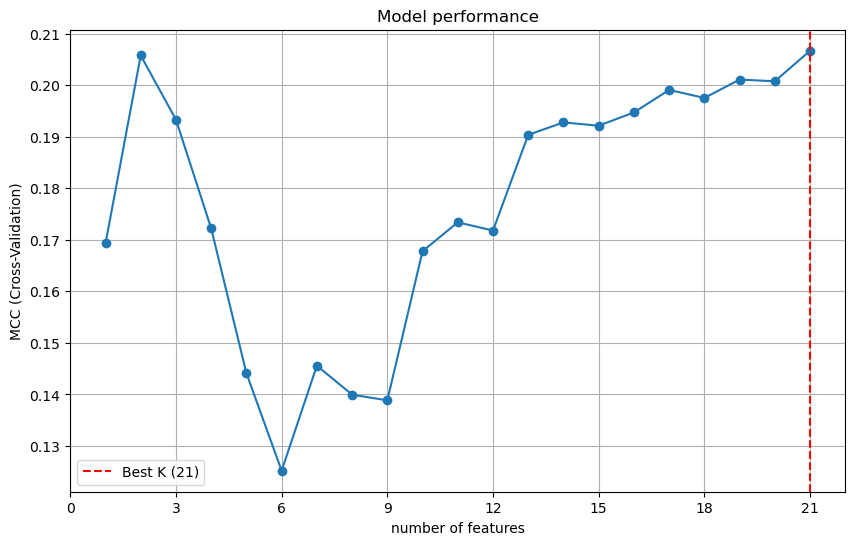

In [29]:
print(f"Optimal number of features: {rfecv.n_features_}")

n_features_range = range(1 , len(rfecv.cv_results_['mean_test_score']) +1)
scores = rfecv.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.xlabel("number of features")
plt.ylabel("MCC (Cross-Validation)")
plt.plot(n_features_range, scores, marker='o')
plt.axvline(rfecv.n_features_, color='red', linestyle='--', label=f'Best K ({rfecv.n_features_})')
plt.title("Model performance")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid()
plt.show()

Selected features:
['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Dumped features:
[]


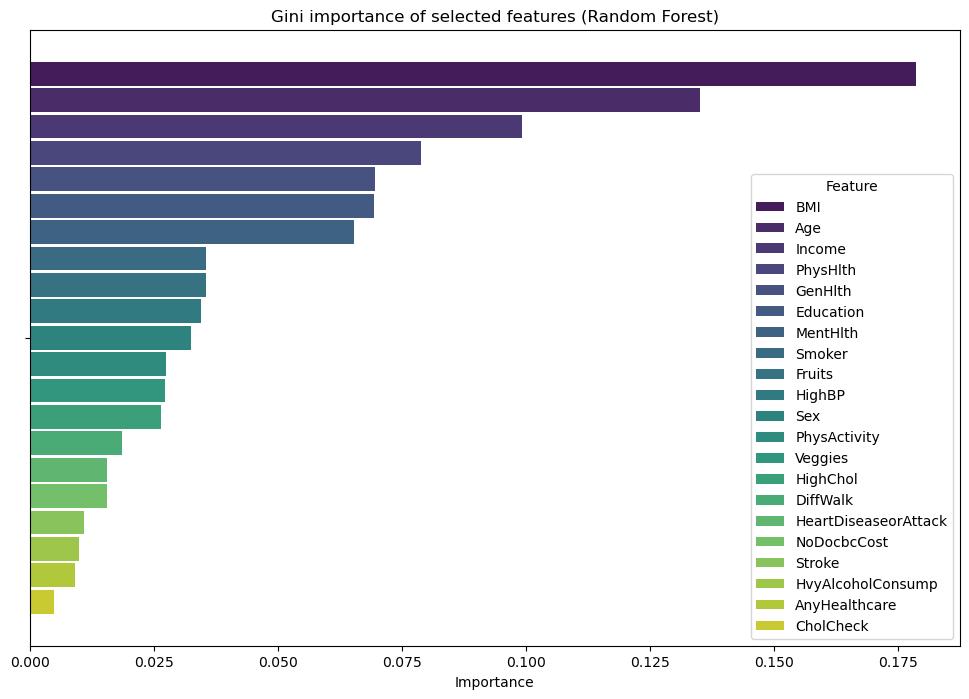

In [30]:
feature_selected = training_x.columns[rfecv.support_]
feature_dumped = training_x.columns[~rfecv.support_]

print("Selected features:")
print(list(feature_selected))

print("Dumped features:")
print(list(feature_dumped))

importances = rfecv.estimator_.feature_importances_

df_imp = pd.DataFrame({
    'Feature': feature_selected,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', hue='Feature', data=df_imp, palette='viridis' , width=0.9 ,gap=0.1)
plt.title("Gini importance of selected features (Random Forest)")
plt.show()

#### Testing cell

In [35]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    training_x, 
    training_vector, 
    test_size=0.2, 
    stratify=training_vector, 
    random_state=42
)

rf_selector.fit(x_train_split, y_train_split)

y_pred = rf_selector.predict(x_test_split)

print(classification_report(y_test_split, y_pred, target_names=['Healthy', 'Pre-diab', 'Diab']))
print(f"MCC:  {matthews_corrcoef(y_test_split , y_pred)}")

              precision    recall  f1-score   support

     Healthy       0.86      0.97      0.91     34193
    Pre-diab       0.00      0.00      0.00       741
        Diab       0.49      0.17      0.25      5655

    accuracy                           0.84     40589
   macro avg       0.45      0.38      0.39     40589
weighted avg       0.79      0.84      0.80     40589

MCC:  0.21180239053300381


Feature selection has yielded poor results:  
all features were selected,  
MCC is very low.  

The problem is probably the highly imbalanced classes and the fact that the prediabetes class is very hard to predict.  
Before proceeding, I need to deal with class imbalance.